### 6.2.2 결정 트리 분류 모델 구현하기

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris

df = load_iris(as_frame=True)['frame']
df = df[df['target'] <= 1]
df = df.sample(frac=1, random_state=1234)

train, test = df.iloc[:75, :], df.iloc[75:, :]
X_train, y_train = train.iloc[:, :-1], train.iloc[:, -1]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]
X_cols, y_col = train.columns.tolist()[:-1], train.columns.tolist()[-1]

In [2]:
max_depth = 4
min_samples_split = 4

In [3]:
def eval_gini(left, right, y_col):
    gini, n1, n2 = 0, len(left), len(right)
    
    score = 1 - ((left[y_col].value_counts())**2).sum() / (n1**2)
    gini += score * n1 / (n1 + n2)

    score = 1 - ((right[y_col].value_counts())**2).sum() / (n2**2)
    gini += score * n2 / (n1 + n2)

    return gini

In [4]:
def eval_class(df, y_col):
    return df[y_col].value_counts().sort_values(ascending=False).index[0]

In [5]:
tree = []
for i in range(0, 2**(max_depth + 1)):
    tree.append(dict({'struct': None}))

tree[1]['struct'] = train

In [6]:
for i in range(1, len(tree)):

    # 트리가 끝난 부분은 통과
    if not isinstance(tree[i]['struct'], pd.DataFrame): continue
    
    # 최대 깊이 도달하였으면 클래스를 출력
    if i >= 2**max_depth:
        tree[i]['struct'] = eval_class(tree[i]['struct'], y_col)
        continue
    
    data = tree[i]['struct']
    a, b, c, d, e = '', float('inf'), float('inf'), None, None
    
    # 최고의 피처와 임계값을 찾은 후 그 기준으로 분할
    for X_col in X_cols: 
        vals = np.sort(data[X_col].unique())
        for val in vals[1:]:
            left, right = data[data[X_col] < val], data[data[X_col] >= val]

            gini = eval_gini(left, right, y_col)

            if gini < c:
                a, b, c, d, e = X_col, val, gini, left, right
    
    tree[i]['col'] = a
    tree[i]['val'] = b
    if len(d) >= min_samples_split:
        tree[i << 1]['struct'] = d
    else:
        tree[i << 1]['struct'] = eval_class(e, y_col)
    if len(e) >= min_samples_split:
        tree[(i << 1) + 1]['struct'] = e
    else:
        tree[(i << 1) + 1]['struct'] = eval_class(e, y_col)

In [7]:
cnt = 0
for i in range(len(X_train)):
    row = X_train.iloc[i]
    ind = 1
    node = tree[ind]
    while isinstance(node['struct'], pd.DataFrame):
        if row[node['col']] < node['val']:
            ind = ind << 1
        else:
            ind = (ind << 1) + 1
        node = tree[ind]

    y_pred = node['struct']
    cnt += (y_pred == y_train.iloc[i]) * 1
    
print(f'학습 데이터셋 정확도:{cnt / len(y_train) * 100: .2f}%')

학습 데이터셋 정확도: 100.00%


In [8]:
cnt = 0
for i in range(len(X_test)):
    row = X_test.iloc[i]
    ind = 1
    node = tree[ind]
    while isinstance(node['struct'], pd.DataFrame):
        if row[node['col']] < node['val']:
            ind = ind << 1
        else:
            ind = (ind << 1) + 1
        node = tree[ind]

    y_pred = node['struct']
    cnt += (y_pred == y_test.iloc[i]) * 1
    
print(f'테스트 데이터셋 정확도:{cnt / len(y_test) * 100: .2f}%')

테스트 데이터셋 정확도: 100.00%


### [예제 6.1] DecisionTreeClassifier 클래스 사용하기

In [9]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X, y = load_iris(return_X_y=True, as_frame=False)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=1234)

In [10]:
clf = DecisionTreeClassifier(criterion='entropy',
                             max_depth=3,
                             min_samples_split=3,
                             random_state=1234)
clf = clf.fit(X_train, y_train)

In [11]:
y_pred = clf.predict(X_test)
acc = (y_pred == y_test).sum() / len(y_test)
print(f'정확도:{acc * 100: .2f}%')

정확도: 98.00%


### [예제 6.2] 트리 구조의 이해

In [12]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
%matplotlib inline

X, y = load_iris(return_X_y=True, as_frame=False)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=1234)

In [13]:
clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=1234)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=3, random_state=1234)

[Text(0.4, 0.8333333333333334, 'X[2] <= 2.6\ngini = 0.667\nsamples = 100\nvalue = [33, 33, 34]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 33\nvalue = [33, 0, 0]'),
 Text(0.6, 0.5, 'X[3] <= 1.65\ngini = 0.5\nsamples = 67\nvalue = [0, 33, 34]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.157\nsamples = 35\nvalue = [0, 32, 3]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.061\nsamples = 32\nvalue = [0, 1, 31]')]

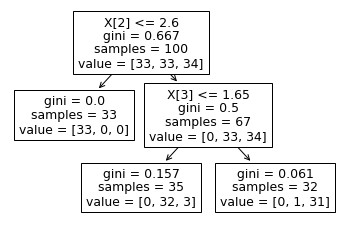

In [14]:
tree.plot_tree(clf)

In [15]:
y_pred = clf.predict(X_test)
acc = (y_test == y_pred).sum() / len(y_test)
print(f'정확도:{acc*100: .2f}%')

정확도: 96.00%


### [예제 6.3] 그리드 서치로 결정 트리의 하이퍼파라미터 튜닝하기

In [16]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X, y = load_breast_cancer(return_X_y=True, as_frame=False)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=1234)
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.33,
                                                  random_state=1234)

In [17]:
max_depths = [None, 3, 6]
min_samples_splits = [2, 3, 4]
max_featuress = ['sqrt', 'log2', None]

In [18]:
from itertools import product

best_max_depth = None
best_min_samples_split = None
best_max_features = None

best_acc = 0

for max_depth, min_samples_split, max_features in product(max_depths, min_samples_splits, max_featuress):
    clf = DecisionTreeClassifier(random_state=1234,
                                 max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 max_features=max_features)
    y_pred = clf.fit(X_train, y_train).predict(X_val)
    
    acc = (y_pred == y_val).mean()
    if acc > best_acc:
        best_acc = acc
        best_max_depth = max_depth
        best_min_samples_split = min_samples_split
        best_max_features = max_features

print('max_depth:', best_max_depth, '\nmin_samples_split:', 
      best_min_samples_split, '\nmax_features:', best_max_features)

max_depth: None 
min_samples_split: 2 
max_features: log2


In [19]:
clf = DecisionTreeClassifier(random_state=1234,
                             max_depth=best_max_depth,
                             min_samples_split=best_min_samples_split,
                             max_features=best_max_features)

y_pred = clf.fit(X_train,y_train).predict(X_test)
print(f'정확도:{(y_pred == y_test).mean() * 100: .2f}%')

정확도: 87.77%


## 06 되새김 문제

### [되새김 문제 6.1] 결정 트리의 과적합

#### 문제

In [20]:
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
%matplotlib inline

X, y = make_classification(n_samples=2000,
                           n_features=20,
                           n_informative=15,
                           flip_y=0.2,
                           random_state=1234)
df = pd.DataFrame(X, columns=['Feature' + str(x) for x in range(1, 21)])
df['y'] = y
train, test = df.iloc[:1500, :], df.iloc[1500:, :]
X_train, y_train = train.iloc[:, :-1], train.iloc[:, -1]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]

In [21]:
X2, y2 = make_classification(n_samples=2000,
                             n_features=20,
                             n_informative=3,
                             flip_y=0.99,
                             random_state=1234)
df2 = pd.DataFrame(X2, columns = ['Feature' + str(x) for x in range(1, 21)])
df2['y'] = y2
train2, test2 = df2.iloc[:1500, :], df2.iloc[1500:, :]
X_train2, y_train2 = train2.iloc[:, :-1], train2.iloc[:, -1]
X_test2, y_test2 = test2.iloc[:, :-1], test2.iloc[:, -1]

#### 풀이

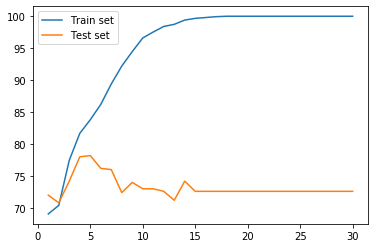

In [22]:
train_acc = []
test_acc = []
max_depths = range(1, 31)
for max_depth in max_depths:
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=1234)
    clf = clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_pred = clf.predict(X_test)
    
    train_acc.append((y_train == y_train_pred).mean() * 100)
    test_acc.append((y_test == y_pred).mean() * 100)
    
plt.plot(max_depths, train_acc, label='Train set')
plt.plot(max_depths, test_acc, label='Test set')
plt.legend()

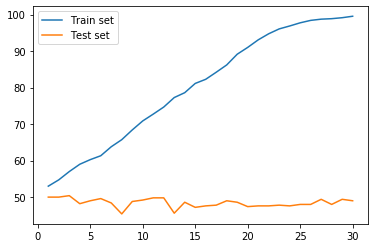

In [23]:
train_acc2 = []
test_acc2 = []
max_depths = range(1, 31)
for max_depth in max_depths:
    clf2 = DecisionTreeClassifier(max_depth=max_depth, random_state=1234)
    clf2 = clf2.fit(X_train2, y_train2)
    y_train_pred2 = clf2.predict(X_train2)
    y_pred2 = clf2.predict(X_test2)
    
    train_acc2.append((y_train2 == y_train_pred2).mean() * 100)
    test_acc2.append((y_test2 == y_pred2).mean() * 100)
    
plt.plot(max_depths, train_acc2, label='Train set')
plt.plot(max_depths, test_acc2, label='Test set')
plt.legend()

### [되새김 문제 6.2] 회귀 트리 구현하기

#### 문제

In [24]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=1234)
train = pd.concat([X_train, y_train], axis = 1)
X_cols, y_col = X.columns.tolist(), y.name

#### 풀이

In [25]:
max_depth = 4
min_samples_split = 4

In [26]:
def eval_mse(left, right, y_col):
    mse, n1, n2 = 0, len(left), len(right)
    score = ((left[y_col] - left[y_col].mean())**2).mean()
    mse += score * n1 / (n1 + n2)
    score = ((right[y_col] - right[y_col].mean())**2).mean()
    mse += score * n2 / (n1 + n2)    
    return mse

def eval_y(df, y_col): 
    return df[y_col].mean()

In [27]:
tree = []
for i in range(0, 2**(max_depth + 1)):
    tree.append(dict({'struct': None}))

tree[1]['struct'] = train

for i in range(1, len(tree)):
    if not isinstance(tree[i]['struct'], pd.DataFrame): continue
    if i >= 2**max_depth:
        tree[i]['struct'] = eval_y(tree[i]['struct'], y_col)
        continue
    
    data = tree[i]['struct']
    a, b, c, d, e = '', float('inf'), float('inf'), None, None
    
    for X_col in X_cols: 
        vals = np.sort(data[X_col].unique())
        for val in vals[1:]:
            left, right = data[data[X_col] < val], data[data[X_col] >= val]
            mse = eval_mse(left, right, y_col)
            if mse < c: a, b, c, d, e = X_col, val, mse, left, right
    
    tree[i]['col'] = a
    tree[i]['val'] = b

    if len(d) >= min_samples_split: tree[i << 1]['struct'] = d
    else: tree[i << 1]['struct'] = eval_y(e, y_col)

    if len(e) >= min_samples_split: tree[(i << 1) + 1]['struct'] = e
    else: tree[(i << 1) + 1]['struct'] = eval_y(e, y_col)

In [28]:
error = 0
for i in range(len(X_train)):
    row = X_train.iloc[i]
    ind = 1
    node = tree[ind]
    while isinstance(node['struct'], pd.DataFrame):
        if row[node['col']] < node['val']: ind = ind << 1
        else: ind = (ind << 1) + 1
        node = tree[ind]

    y_pred = node['struct']
    error += np.abs(y_pred - y_train.iloc[i])
print(f'학습 데이터셋 MAE:{error / len(y_train): .2f}')

error = 0
for i in range(len(X_test)):
    row = X_test.iloc[i]
    ind = 1
    node = tree[ind]
    while isinstance(node['struct'], pd.DataFrame):
        if row[node['col']] < node['val']: ind = ind << 1
        else: ind = (ind << 1) + 1
        node = tree[ind]

    y_pred = node['struct']
    error += np.abs(y_pred - y_test.iloc[i])
print(f'테스트 데이터셋 MAE:{error / len(y_test): .2f}')

학습 데이터셋 MAE: 40.32
테스트 데이터셋 MAE: 45.49


In [29]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(random_state=1234,
                            max_depth=4,
                            min_samples_split=4).fit(X_train, y_train)

y_pred_train = reg.predict(X_train)
print(f'학습 데이터셋 MAE:{(np.abs(y_pred_train - y_train)).mean(): .2f}')

y_pred = reg.predict(X_test)
print(f'테스트 데이터셋 MAE:{(np.abs(y_pred - y_test)).mean(): .2f}')

학습 데이터셋 MAE: 39.30
테스트 데이터셋 MAE: 45.67


### [되새김 문제 6.3] 그리드 서치로 분류 트리의 하이퍼파라미터 튜닝하기

#### 문제

In [30]:
from sklearn.datasets import load_wine
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X, y = load_wine(return_X_y=True, as_frame=True)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=1234)
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.33,
                                                  random_state=1234)

#### 풀이

In [31]:
max_depths = [3, 4, 5]
class_weights = [None, 'balanced']

In [32]:
from itertools import product

best_max_depth, best_class_weight, best_acc = None, None, 0

for max_depth, class_weight in product(max_depths, class_weights):
    clf = DecisionTreeClassifier(random_state=1234,
                                 max_depth=max_depth,
                                 class_weight=class_weight)
    y_pred = clf.fit(X_train, y_train).predict(X_val)
    
    acc = (y_pred == y_val).mean()
    if acc > best_acc:
        best_acc = acc
        best_max_depth = max_depth
        best_class_weight = class_weight

print('best acc:', best_acc, '\nmax_depth:', best_max_depth, '\nclass_weight:', 
      best_class_weight)

best acc: 0.95 
max_depth: 3 
class_weight: None


In [33]:
clf = DecisionTreeClassifier(random_state=1234,
                             max_depth=best_max_depth,
                             class_weight=best_class_weight)

y_pred = clf.fit(X_train, y_train).predict(X_test)
acc = np.abs(y_pred == y_test).mean()
print(f'정확도:{acc * 100: .2f}%')

정확도: 84.75%


### [되새김 문제 6.4] 제약 조건을 없애도 학습 데이터 정확도가 낮은 분류 트리

#### 문제

In [34]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=1234)

#### 풀이

In [35]:
import pandas as pd

f1 = [1, 0] * 10
f2 = [0, 1] * 10
y = [0] * 10 + [1] * 10
df = pd.DataFrame({'f1': 1, 'f2': f2, 'y': y})

X = df[['f1', 'f2']]
y = df['y']

y_pred = clf.fit(X, y).predict(X)

acc = (y_pred == y).mean()
print(f'정확도: {acc*100:.2f}%')

정확도: 50.00%


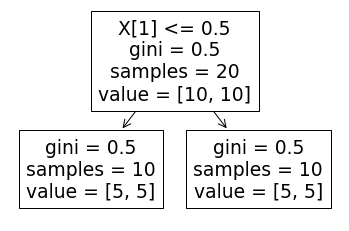

In [36]:
from sklearn import tree
import matplotlib.pyplot as plt

tree.plot_tree(clf)
plt.show()